In [1]:
import sys
import os
import numpy as np 
import matplotlib.pyplot as plt

src_path = os.path.expanduser('~/source/')
sys.path.append(src_path)

In [2]:
#greg tools
sys.path.append(src_path+'simtools')
sys.path.append(src_path+'simtools/infoenginessims')

from integrators import rkdeterm_eulerstoch
from dynamics import langevin_underdamped
import simulation
from simprocedures import basic_simprocedures as sp
from simprocedures import running_measurements as rp
from simprocedures import trajectory_measurements as tp
#from infoenginessims.api import *

In [3]:
#kyle tools
from sus.protocol_designer import Potential, Protocol, System, Compound_Protocol
from informational_states.measure import MeasurementDevice, Measurement, TrajectoryEnsemble
import kyle_tools as kt

In [4]:
# SQUID tools
from FQ_sympy_functions import DeviceParams
from bit_flip_sweep import set_systems, check_device

In [5]:
plt.rcParams['font.size'] = 16
legendsize = 6
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

rc_dict = {'axes.labelsize':'large', 'ytick.right':False,'legend.loc':'upper right', 'legend.fontsize':'xx-small', 'figure.autolayout':True, 'figure.figsize': (12,9)}
plt.rc('grid', linestyle="-", color='black')

for key,value in rc_dict.items():
    plt.rcParams[key] = value

# These are the physical parameters that characterize the system

In [6]:
# set up the device here, for example:
Dev= DeviceParams()

_PHI_0 = 2.067e-15

print('Before change')
print('-------------')
print(f'I_plus, I_minus: {Dev.I_plus}, {Dev.I_minus}')
print(f'L, ell: {Dev.L}, {Dev.ell}')
print(f'R, C: {Dev.R}, {Dev.C}')
print('--------------')

# temp found for current Ray 2023 optimized circuit is T = 0.85
Dev.change_vals({'I_plus':20e-6, 
                 'I_minus':0, 
                 'L':26.3e-12, 
                 'ell':6.58e-12,
                 'R':1_000, 
                 'C':0.03e-12, # from T2018 cited process
                  })

print('After change 1: ')
print('-------------')
print(f'I_plus, I_minus: {Dev.I_plus}, {Dev.I_minus}')
print(f'L, ell: {Dev.L}, {Dev.ell}')
print(f'R, C: {Dev.R}, {Dev.C}')
print('--------------')
print('--------------')


# R big is more damping, less noise --> inertial effects disregarded
print('Before change 2:')
print('----------------')
print(f'U_0: {Dev.U_0}')
print(f'gamma: {Dev.gamma}')
print(f'beta: {Dev.beta}')
print('----------------')


Dev.change_vals({'U_0':_PHI_0**2/(4*np.pi**2*Dev.L),
                 'gamma':Dev.L / (2*Dev.ell),
                 'beta':2*np.pi*Dev.I_plus*Dev.L/_PHI_0
                  })

print('After change 2:')
print('----------------')
print(f'U_0: {Dev.U_0}')
print(f'gamma: {Dev.gamma}')
print(f'beta: {Dev.beta}')
print('----------------')
print('----------------')

check_device(Dev)
print('Before change 3')
print('----------------')
print(f'kT_prime (k_BT/U_0): {Dev.kT_prime}')
print('----------------')

# For FQ
#Dev.change_vals({'kT_prime':((0.85*1.38e-23)/Dev.U_0)})
# For QFP
Dev.change_vals({'kT_prime':((4.2*1.38e-23)/Dev.U_0)})


print('After change 3')
print('----------------')
print(f'kT_prime (k_BT/U_0): {4.2*1.38e-23/Dev.U_0}')
print('----------------')
print('----------------')
print()
print('Some device checks')
print('------------------')
print(f'Temperature of device: {Dev.get_temp()}')
print(f'Dev.alpha, Phi_0/(2pi): {Dev.alpha}, {_PHI_0/(2*np.pi)}')
print(f'alpha**2/L, Phi_0**2/4pi**2 L: {Dev.alpha**2/Dev.L}, {_PHI_0**2/(4*np.pi**2*Dev.L)}')
print('------------------')
print('------------------')


#some alternate parameter sets

#params 1:
#kT_prime = .11
#C = 10*400E-12
#R = 371
#L = 10E-10

#params 2:
#kT_prime = 6.9E-24/1.38E-23
#C = 530E-15
#R = 2.1
#L = 140E-12

Before change
-------------
I_plus, I_minus: 2.039634257699875e-06, 3.2897326737094766e-08
L, ell: 1e-09, 4.166666666666667e-11
R, C: 371, 4e-09
--------------
After change 1: 
-------------
I_plus, I_minus: 2e-05, 0
L, ell: 2.63e-11, 6.58e-12
R, C: 1000, 3e-14
--------------
--------------
Before change 2:
----------------
U_0: 4.114958579647035e-21
gamma: 1.9984802431610942
beta: 1.598914113002643
----------------
After change 2:
----------------
U_0: 4.114958579647034e-21
gamma: 1.9984802431610942
beta: 1.598914113002643
----------------
----------------
Before change 3
----------------
kT_prime (k_BT/U_0): 0.05228074005701463
----------------
After change 3
----------------
kT_prime (k_BT/U_0): 0.01408519645536058
----------------
----------------

Some device checks
------------------
Temperature of device: 4.2
Dev.alpha, Phi_0/(2pi): 3.2897326737094763e-16, 3.2897326737094763e-16
alpha**2/L, Phi_0**2/4pi**2 L: 4.114958579647034e-21, 4.114958579647033e-21
------------------
------

In [7]:
check_device(Dev)

In [8]:
#params Dev:
kT = Dev.get_temp()*1.38E-23
C = Dev.C
R = Dev.R
L = Dev.L

#these are some relevant dimensionful scales: alpha is the natural units for the JJ fluxes and U_0 is the natural scale for the potential
alpha = Dev.alpha

#IMPORTANT: all energies are measured in units of U_0
U_0 = alpha**2 / L
h = 6.63E-34

#these are important dimensionless simulation quantities, accounting for 
#m being measured in units of C, lambda in units of 1/R, energy in units of U_0
m_prime = np.array((1, 1/4))
lambda_prime = np.array((2, 1/2))
kT_prime = Dev.kT_prime
U_0 = Dev.U_0

print('Common Circuit Parameters characterizations')
print('------------')
print(f'characteristic time sqrt(LC):     {np.sqrt(L*C):.2e}')
Q = R*np.sqrt(C/L)
print( 'Q:                                {:.2f}'.format(Q))
frq = 1/(2*np.pi*np.sqrt(L*C))
print('f_LC in GHz:                      {:.2f}'.format(frq/1E9))
print('ring down:                        {:.2f} ns'.format(1E9*Q/frq))
print('ring down in sqrt(LC):            {:.2f}'.format( (Q/frq)/np.sqrt(L*C)))
j_c = alpha/L
print('I_c density (microAmps):          {:.2f}'.format(1E6*j_c))
print('Energy Scale ~ U_0/kT:            {:.2f}'.format(1/Dev.kT_prime))
print(f'quantumness if < 1 ~ kT/(h*f):    {Dev.kT_prime*U_0 / (h*frq):.2f}',)

Common Circuit Parameters characterizations
------------
characteristic time sqrt(LC):     8.88e-13
Q:                                33.77
f_LC in GHz:                      179.18
ring down:                        0.19 ns
ring down in sqrt(LC):            212.21
I_c density (microAmps):          12.51
Energy Scale ~ U_0/kT:            71.00
quantumness if < 1 ~ kT/(h*f):    0.49


In [9]:
Dev.get_params()

L: 2.6300000000000005e-11
ell: 6.58e-12
beta: 1.5989141130026434
R: 1000
kT_prime: 0.01408519645536058
U_0: 4.114958579647034e-21


# Here we define the $\varphi_{xdc}$ protocol

In [10]:
### protocol 1: matching protocol to how I'd expect ###
# this is the "flux qubit" potential, it depends on 5 parameters: [phi_x, phi_xdc, gamma, Beta, deltaBeta]
from sus.library.fq_systems import fq_pot
import sus.protocol_designer as designer

# define the default protocol values, we will only change phi_xdc so the others will stay at the default values.
default_values = [0, 0, Dev.gamma, Dev.beta, Dev.dbeta]
print(f'default_values: {default_values}')

# changing the first and second parameters
which_params = [1, 2]

# not sure if these are completely correct yet, will need to test
_pxdc_dw = -0.01
_pxdc_sw = -3.14

'''  T2018 STEPS
 1) double well to start, 
 2) wait 1 ns for equilibration
 
 3) barrier drop start
 4) barrier drop end
 5) wait 1 ns
 
 6) tilt begins
 7) tilt end
 8) wait 1 ns
 
 9) barrier raise start
 10) barrier raise end
 11) wait 1 ns
 
 12) untilt start
 13) untilt end
 14) pause at end for 1 ns
'''
phi_xdc_values = [_pxdc_dw, # 1
                  _pxdc_dw, # 2
                  _pxdc_dw, # 3
                  _pxdc_sw, # 4
                  _pxdc_sw, # 5
                  _pxdc_sw, # 6
                  _pxdc_sw, # 7
                  _pxdc_sw, # 8
                  _pxdc_sw, # 9
                  _pxdc_dw, # 10
                  _pxdc_dw, # 11
                  _pxdc_dw, # 12
                  _pxdc_dw, # 13
                  _pxdc_dw, # 14
                 ]

_px_tilt = 0.24
phi_x_values = [0, # 1
                0, # 2
                0, # 3
                0, # 4
                0, # 5
                0, # 6
                _px_tilt, # 7
                _px_tilt, # 8
                _px_tilt, # 9
                _px_tilt, # 10
                _px_tilt, # 11
                _px_tilt, # 12
                0, # 13
                0, # 14
               ]

phi_values = [phi_x_values, phi_xdc_values]

# time in sqrt LC for each substep
start_time = 5 

# will need to change this depending on dt, needs to match:
# tau_rise = 1 ns in units of dt 
tau_rise = 1125 # for dt = sqrt(LC) \approx 1 ps

# keyframe times in terms of number of phi_xdc / phi_x values we'll have
keyframe_times = [0] + [i*tau_rise for i in list(range(1, len(phi_xdc_values), 1))]

#protcol has 5 parameters to keep track of
num_params = 5
# and the number of steps is the number of times minus one
num_steps = len(keyframe_times)-1

# this function allows us to set a time dependent potential over several steps
keyframe_protocol = designer.protocol.sequential_protocol

# now use the keyframe_protocol function to create the protocol
protocol = keyframe_protocol(num_steps, num_params, which_params, phi_values, keyframe_times, default_values)

# after the fact, you can go through and change the interpolation method for each step. Uf you set this boolean to "true" it will do instant steps instead of linear
# this will mean there is no ramp up time.
use_step_interpolation = False
if use_step_interpolation:
    protocol.protocols[1].interpolation = 'step'
    protocol.protocols[-1].interpolation = 'end_step'

# now we define the system, a class that applies the created protocol to the potential for the flux qubit
comp = System(protocol, fq_pot)

default_values: [0, 0, 1.9984802431610946, 1.5989141130026434, 0.0]


t, p_array[:, i]: [0.00000000e+00 1.60891089e+00 3.21782178e+00 ... 1.60842822e+04
 1.60858911e+04 1.60875000e+04], [-0.01 -0.01 -0.01 ... -0.01 -0.01 -0.01]
t, p_array[:, i]: [0.00000000e+00 1.60891089e+00 3.21782178e+00 ... 1.60842822e+04
 1.60858911e+04 1.60875000e+04], [-0.01 -0.01 -0.01 ... -0.01 -0.01 -0.01]


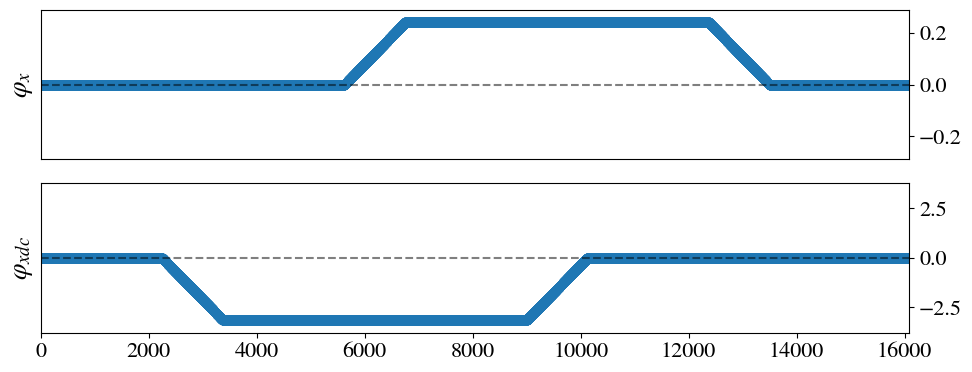

In [11]:
# plots the protocol parameters over time, time is in units of sqrt(LC)
fig, ax = comp.protocol.show_params(which=[1,2], resolution=10_000, param_labels=['$\\varphi_{x}$', '$\\varphi_{xdc}$'], show=False);
fig.set_size_inches(10, 4)

In [12]:
#this cell defines what system you want to simulate and how many trials to run.
#generally no need to do lots of trials while prototyping protocols

N = 5_000
system = comp
eq_sys = comp

system.mass= m_prime
eq_sys.mass = m_prime

system.potential.scale=1

#initialize the state in an EQ distribution.

### SETTING THE INITIAL TIME DOESN'T WORK --- NEED TO FOLLOW UP!
# why doesn't this happen in the "auto" protocol for [0.3, 0.3],
# but this is happening right now?
# changing below
#initial_state = eq_sys.eq_state(N, t=0, beta=1/(kT_prime), resolution=1_000, manual_domain=[[-4,-4],[4,0]], axes=[1,2])
initial_state = eq_sys.eq_state(N, t=0, beta=1/(kT_prime), resolution=1_000, manual_domain=[[-4,-2],[4,2]], axes=[1,2])

 found 5000 samples out of 5000

# Next few cells are visualization checks that your system is set up how you want

Text(0.5, 0.98, 'Generalized Equipartition Theorem: $\\langle x_i \\partial_{x_j} H\\rangle - I \\text{ with } x_1, x_2, x_3, x_4 = \\varphi, \\varphi_{dc}, \\dot{\\varphi}, \\dot{\\varphi}_{dc}$')

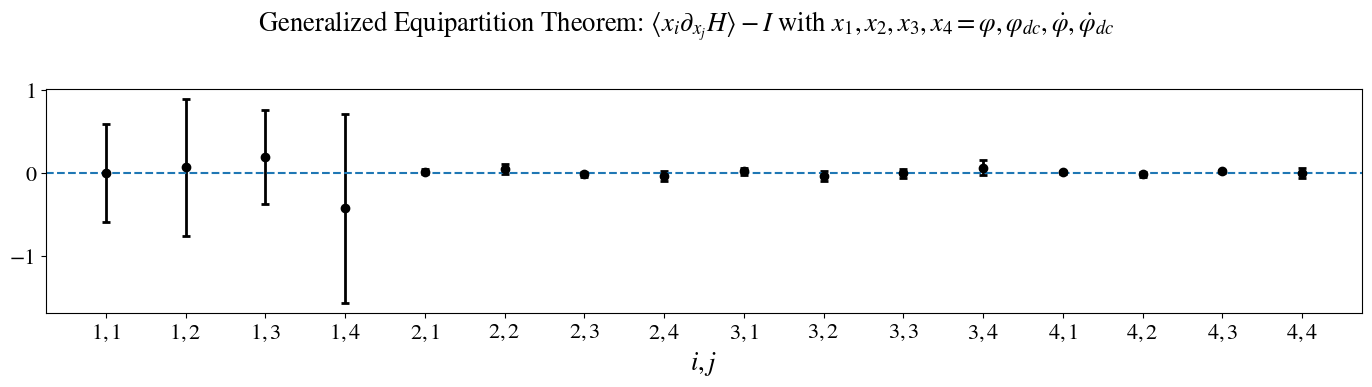

In [13]:
#this cell checks for closeness to equilibrium by checking the generalized equipartition theorem
#the true equilibrium dist will yield zeros for all elements, but only when when n -> infinity
#this can take a lot of trials to converge

I = np.zeros((4,4))
for i in range(4):
    I[i,i] = 1

ept_test = system.check_local_eq(initial_state, 0)/kT_prime - I 
ept_mean, ept_std = np.mean(ept_test, axis=0), np.std(ept_test, axis=0)

element_labels = [ f'${i+1},{j+1}$' for i in range(4) for j in range(4)]

fig, ax = plt.subplots(figsize=(14,4))

ax.errorbar(element_labels, ept_mean.ravel(), yerr = 3*ept_std.ravel()/np.sqrt(N), fmt='o', capsize=3, capthick=2, elinewidth=2, color='black')
ax.axhline(linestyle='--')
ax.set_xlabel('$i,j$')
fig.suptitle('Generalized Equipartition Theorem: '+'$\\langle x_i \\partial_{x_j} H\\rangle - I \\text{ with } x_1, x_2, x_3, x_4 = \\varphi, \\varphi_{dc}, \\dot{\\varphi}, \\dot{\\varphi}_{dc}$')

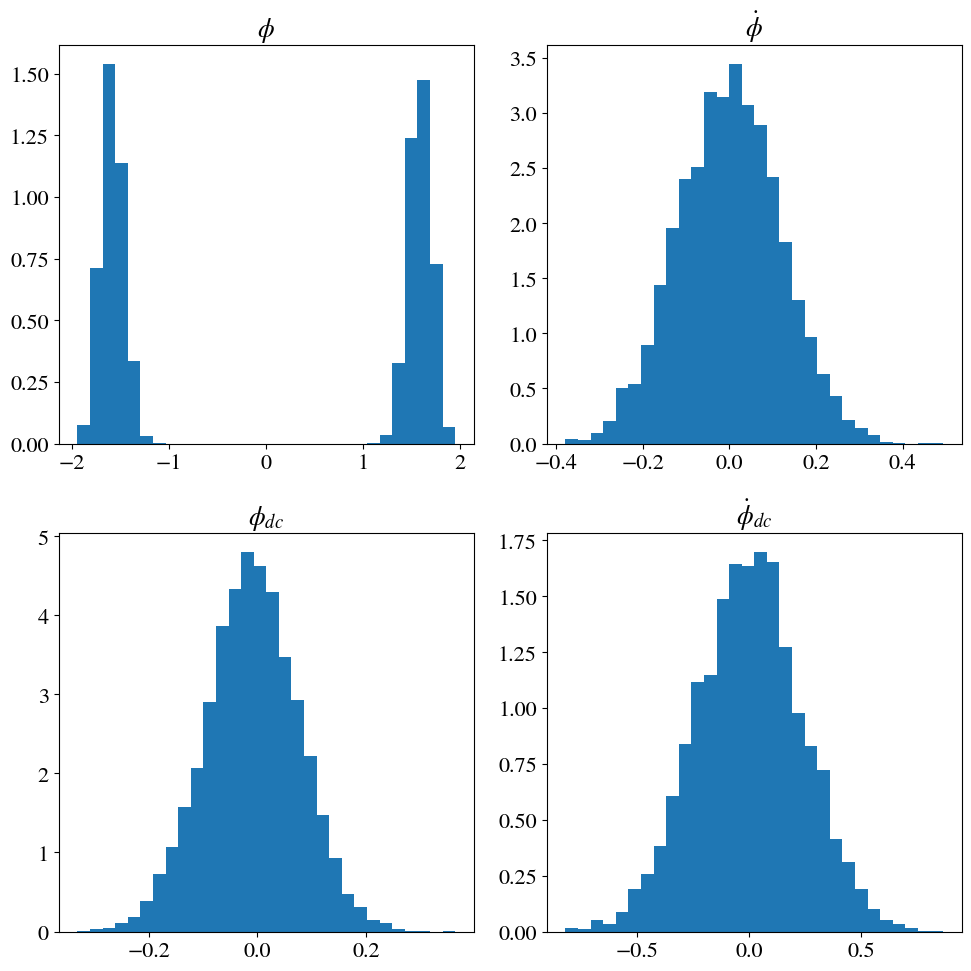

In [14]:
#this cell is for checking that the initial state is what you want qualitatively, shows phase space histograms
nbins= 30

fig, ax = plt.subplots(2,2, figsize=(10,10))

for i in range(0, 1+1, 1):
    for j in range(0, 1+1, 1):
        ax[i, j].hist(initial_state[:, i,j], bins=nbins, density=True)

titles = ['$\\phi$', '$\\dot{\\phi}$', '$\\phi_{dc}$', '$\\dot{\\phi}_{dc}$']
for i, axis in enumerate(ax.ravel()):
    axis.set_title(titles[i])

In [15]:
system.protocol

t_i, t_f: 0.0, 14625.0


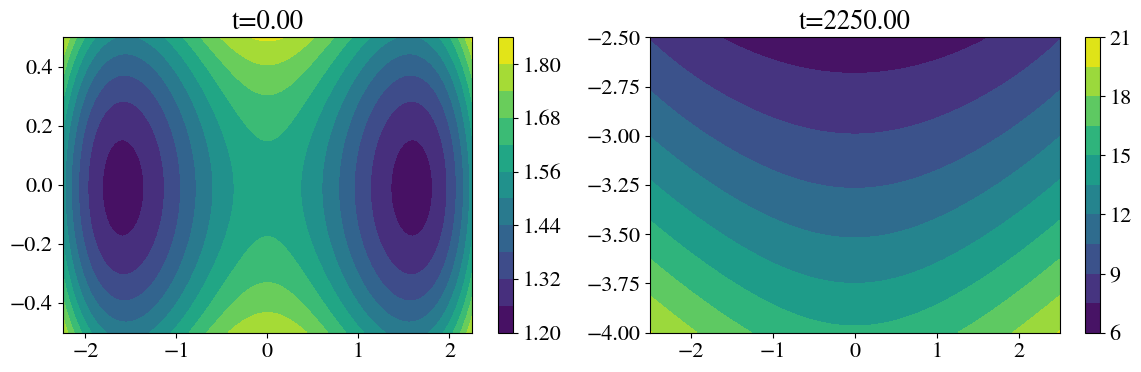

In [16]:
#gives a snapshot of the potential at some time in some domain
fig, ax = plt.subplots(1,2, figsize=(12,4))
t_snapshot = system.protocol.t_i 
#t_snapshot = system.protocol.t_f - 0.005

#### all for 0.8, 0.8
## double well: [[-4,-1.8],[4,-1]]
## single well
# [[-4,-4],[4,-2.5]]

### all for 0.4, 0.4
# double well: [[-2.75, -2.3],[2.75, -1.3]]
# single well: 

# for quasistatic erasure
_domain_i = [[-2.25, -0.5],[2.25, 0.5]]

fig, _, out = system.show_potential(t_snapshot, manual_domain=_domain_i, figax=[fig,ax[0]], surface=False, show=False)
#fig, ax[1], out = system.show_potential(t_snapshot, manual_domain=[[-4,-4],[4,-2.5]], figax=[fig,ax[1]], surface=False, show=False)
print(f't_i, t_f: {system.protocol.t_i}, {system.protocol.t_f}')

#t_snapshot_f = system.protocol.t_i + 15 + 0.005
#t_snapshot_f = system.protocol.t_f - 0.005
t_snapshot_f = system.protocol.t_i + 2*tau_rise
_domain_f = [[-2.5,-2.5],[2.5, -4]]
fig, ax[1], out = system.show_potential(t_snapshot_f, manual_domain=_domain_f, figax=[fig,ax[1]], surface=False, show=False)
#fig, _, out = system.show_potential(t_snapshot_f, manual_domain=[[-4,-1.8],[4,-1]], figax=[fig,ax[0]], surface=False, show=False)

# Now we set up the simulation

In [17]:
# this sets up our simulation to do underdamped langevin dynamics.
# if you want to change the temperature or damping by some amount, you can change the scale factors in this cell
# probably dont want to change anythign else in here though

#NOTE: changing the temperature here will not change the temperature used to generate the EQ distribution,
#NOTE: time is scaled in units of sqrt(LC)

gamma = (lambda_prime/m_prime) * np.sqrt(L*C) / (R*C) 
theta = 1/m_prime
eta = (L/(R**2 * C))**(1/4) * np.sqrt(kT_prime*lambda_prime) / m_prime        

damping_scale = 1
temp_scale = 1

gamma = np.multiply(gamma, damping_scale)
eta = np.multiply(eta, np.sqrt(damping_scale*temp_scale))

dynamic = langevin_underdamped.LangevinUnderdamped(theta, gamma, eta, system.get_external_force)
dynamic.mass = system.mass

integrator = rkdeterm_eulerstoch.RKDetermEulerStoch(dynamic)

In [18]:
#dont change this cell unless you take a look at how the procedures work, this should be fine for most use cases

is_bools = kt.separate_by_state(initial_state[...,0,0])

## commenting out certain procedures for memory saving
# all work is for trajectory information
# final work is keeping track of work moment to moment, and just keeps array
procedures = [
              sp.ReturnFinalState(),
              sp.MeasureAllState(trial_request=slice(0, 1000), step_request=np.s_[::4]),
              #rp.MeasureAllValue(rp.get_dW, 'all_W'),
              rp.MeasureFinalValue(rp.get_dW, 'final_W'),
              #sp.MeasureMeanValue(rp.get_kinetic, output_name='kinetic' ),
              #sp.MeasureMeanValue(rp.get_potential, output_name='potential'),
              #sp.MeasureMeanValue(rp.get_EPT, output_name='equipartition'),
              sp.MeasureMeanValue(rp.get_current_state, output_name = 'zero_means', trial_request=is_bools['0']),
              sp.MeasureMeanValue(rp.get_current_state, output_name = 'one_means', trial_request=is_bools['1']),
              tp.CountJumps(state_slice=np.s_[...,0,0])
             ]

In [19]:
# here is where you choose the number of steps to simulate and how long to run the sim for.
# note that if your time is longer than the protocol time, the potential will just sit at its final value.
print(f'{system.protocol.t_f-system.protocol.t_i}')
total_time = (system.protocol.t_f-system.protocol.t_i) + 2

print(f'total time: {total_time*np.sqrt(Dev.L * Dev.C)}:')

#dt = 0.2e-12 / np.sqrt(Dev.L*Dev.C) for Takeuchi 2018
#   = 0.23
dt = 1 
print(f'dt: {dt}')
print(f'tau_rise (\sqrt(LC)) = 1e-9 / dt = {1e-9 / (dt*np.sqrt(Dev.L*Dev.C))}')
print(f'tau_rise for verification: {tau_rise}') # could throw try-except error but not doing it for now
print(f'===> go back and change if not the same')

nsteps = int(total_time/dt)
nsteps_quick = int(nsteps/10)

sim = simulation.Simulation(integrator.update_state, procedures, nsteps, dt,
                            initial_state)

sim.system = system

14625.0
total time: 1.2992531038292734e-08:
dt: 1
tau_rise (\sqrt(LC)) = 1e-9 / dt = 1125.8006586160939
tau_rise for verification: 1125
===> go back and change if not the same


# Run simulation

In [20]:
%%time
sim.output = sim.run(verbose=True)

 step 14627 of 14627 completeCPU times: user 1min 5s, sys: 124 ms, total: 1min 5s
Wall time: 1min 5s


In [23]:
# Here we assign sim output to some variables for easier access later
# this is a bit of a mess, but it works for now

# this saves trajectory data for the first 1,000 samples. It only saves every 4 time steps to save on memory. this is set in procedures
all_state = sim.output.all_state['states']
# work over time, all trials, all time steps
#all_W = sim.output.all_W
# net work at the end per trial
final_W = sim.output.final_W
# the full final state
final_state = sim.output.final_state
# equipartition checks over time, ['values'] is the mean, ['std_error'] is the std error
#all_EPT = sim.output.equipartition['values']
# average KE, PE of all particles over time
#all_KE = sim.output.kinetic['values']
#all_PE = sim.output.potential['values']
# arrays to plot time on the x axis
times = np.linspace(0, total_time, nsteps+1)
# coarse grained version for plotting all_state
all_times = np.linspace(0, total_time, all_state.shape[1])
# info state conditioned averages for each phase space coordinate
z_states = sim.output.zero_means['values']
z_err = np.sqrt(N)*sim.output.zero_means['std_error']
o_states = sim.output.one_means['values']
o_err = np.sqrt(N)*sim.output.one_means['std_error']

# this measures every time the sign of phi changes form + to - 
jumps = sim.output.trajectories

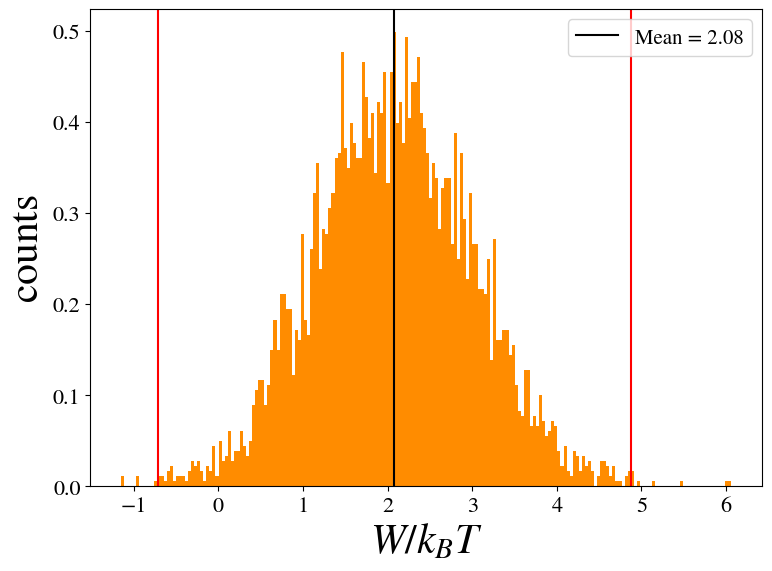

In [24]:
import json
fig, ax = plt.subplots(1,1, figsize=(8,6))

label_size = 20
plt.rc('xtick', labelsize=label_size)
plt.rc('ytick', labelsize=label_size)
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

#ax.set_title('Final Work (kT) histogram')
final_W_kT = final_W/kT_prime
ax.hist(final_W_kT, bins=200, color='darkorange', density=True)
m=(final_W_kT).mean()
s=(final_W_kT).std()
ax.axvline(m, color='k', label=f'Mean = {m:.2f}')
ax.axvline(m-3*s, color='r')
ax.axvline(m+3*s, color='r')

ax.set_xlabel(r'$W / k_BT$', fontsize=30)
ax.set_ylabel(r'$\mathrm{counts}$', fontsize=30)

ax.legend(fontsize=15)

#print(f'mean: {m}')
with open('Langevin_work_erasure-list-new.json', 'w') as f:
    json.dump(final_W_kT.tolist(), f)

In [ ]:
####### WARNING: This plot takes up a LOT of RAM.
fig, ax = plt.subplots()
all_ke  = system.get_kinetic_energy(all_state) / kT_prime

ax.plot(all_times, all_ke.T, alpha=.005);
ax.plot(times, all_KE/kT_prime, zorder=10000, linewidth=1, color='k', label='ensemble average' );
ax.axhline(1, linestyle='--', color='k', alpha=.2, label='kT')
fig.legend()
fig.suptitle('total Kinetic Energy')

In [ ]:
fig, ax = plt.subplots(2,2)

coarse = 25
for i in range(2):
    for j in range(2):
        for state, error in zip([z_states, o_states],[z_err, o_err]):
            markers, caps, bars = ax[i,j].errorbar(times[::coarse], state[::coarse,i,j], yerr=error[::coarse,i,j], alpha=.6);
            [bar.set_alpha(.2) for bar in bars]
            for lineval in [ state[0,i,j] + item*error[0,i,j] for item in[-1,1]]:
                ax[i,j].axhline(lineval, linestyle='--', color='k', alpha=.2)

_ax_fontsize = 25
ax[0,0].set_ylabel('$\\varphi$', fontsize=_ax_fontsize)
ax[0,1].set_ylabel('$\\dot{\\varphi}$', fontsize=_ax_fontsize)
ax[1,0].set_ylabel('$\\varphi_{\mathrm{dc}}$', fontsize=_ax_fontsize)
ax[1,1].set_ylabel('$\\dot{\\varphi}_{\mathrm{dc}}$', fontsize=_ax_fontsize)

#ax[0,0].set_xticklabels([])
ax[0,1].set_xticklabels([])
ax[0,0].set_xlabel(r'$t \; (\sqrt{LC})$', fontsize=_ax_fontsize)

ax[1,0].set_xlabel(r'$t \; (\sqrt{LC})$', fontsize=_ax_fontsize)
ax[1,1].set_xlabel(r'$t \; (\sqrt{LC})$', fontsize=_ax_fontsize)

xadjust = 2
#endtime = 5+(2*ramp_time)
#for i in range(0, 1+1, 1):
#    for j in range(0, 1+1, 1):
#        ax[i,j].axvline(x=5, linestyle='--', color='black')
#        ax[i,j].axvline(x=endtime, linestyle='--', color='black')
#       ax[i,j].set_xlim([5-xadjust, endtime+xadjust])
        
#ax[0,0].set_title('$\\phi$')
#ax[0,1].set_title('$\\dot{\\phi}$')
#ax[1,0].set_title('$\\phi_{dc}$')
#ax[1,1].set_title('$\\dot{\\phi}_{dc}$')

#fig.suptitle('Info State Average and Std Deviation')

In [ ]:
fig, ax = plt.subplots(2,2)

coarse = 25
for i in range(2):
    for j in range(2):
        for state, error in zip([z_states, o_states],[z_err, o_err]):
            markers, caps, bars = ax[i,j].errorbar(times[::coarse], state[::coarse,i,j], yerr=error[::coarse,i,j], alpha=.6);
            [bar.set_alpha(.2) for bar in bars]
            for lineval in [ state[0,i,j] + item*error[0,i,j] for item in[-1,1]]:
                ax[i,j].axhline(lineval, linestyle='--', color='k', alpha=.2)


ax[0,0].set_title('$\\phi$')
ax[0,1].set_title('$\\dot{\\phi}$')
ax[1,0].set_title('$\\phi_{dc}$')
ax[1,1].set_title('$\\dot{\\phi}_{dc}$')

fig.suptitle('Info State Average and Std Deviation')

In [ ]:
'''
fig, ax = plt.subplots(1,1, figsize=(15,5))

#ax[0].set_title('Work (kT) vs time')
#all_W_kT = all_W/kT_prime
#all_W_kT = all_W

#ax[0].plot(times, all_W_kT.T, alpha=.1);
#ax[0].plot(times, all_W_kT.mean(axis=0), linewidth=2, color='k', label='ensemble average', alpha=1 );

#ax[0].legend()

#this will show you a histogram of the net work, with the mean and +- sigma marked
#note the energy scale is in k_B T

ax[1].set_title('Final Work (kT) histogram')
final_W_kT = final_W/kT_prime
ax[1].hist(final_W_kT, bins=30)
m=(final_W_kT).mean()
s=(final_W_kT).std()
ax[1].axvline(m, color='k', label='mean')
ax[1].axvline(m-3*s, color='k', label=' - 3 sigma')
ax[1].axvline(m+3*s, color='k', label=' + 3 sigma')
ax[1].legend()

print(m)
'''

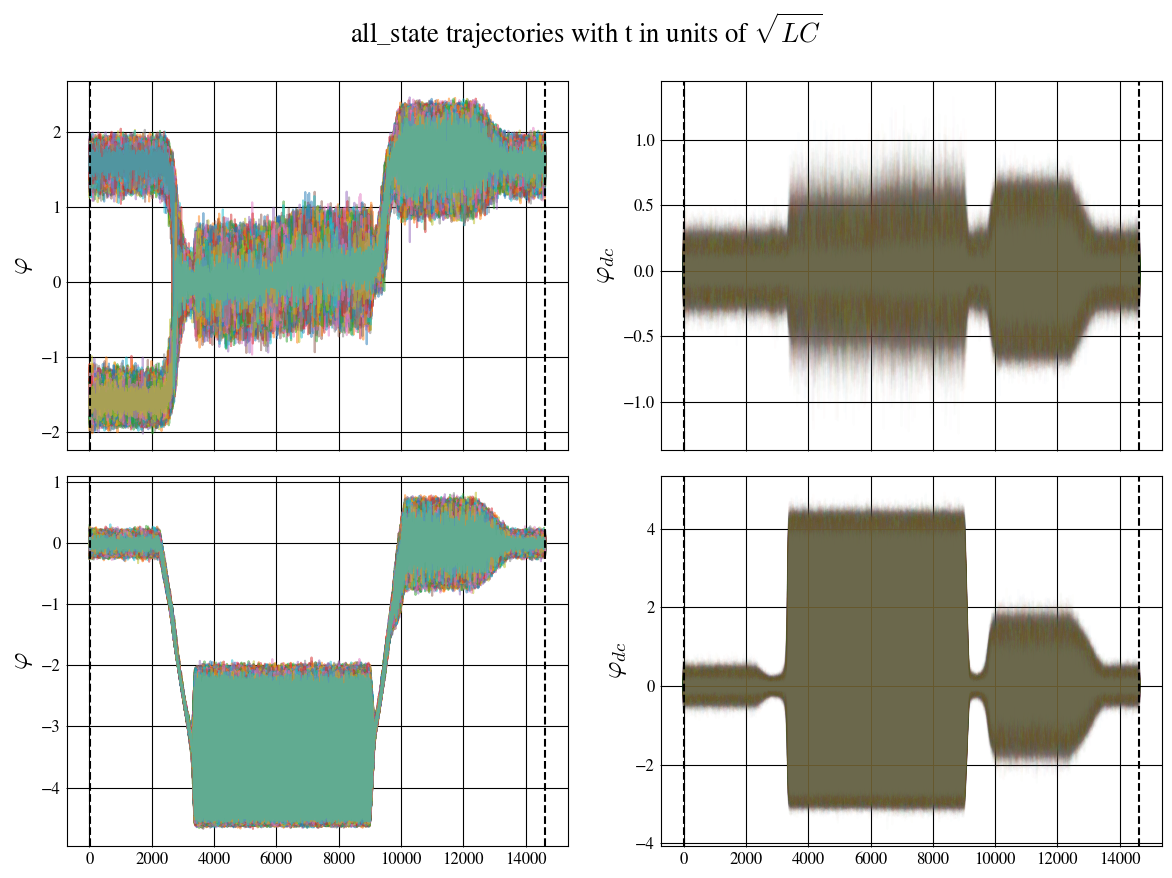

In [25]:
for item in rc_dict:
    plt.rcParams[item] = rc_dict[item]

# dont need ot look at all of them, this will show every 10th
fig, ax = plt.subplots(2,2, sharex=True)

opacity_values = [.5, .01]
trial_indices = np.s_[::1], np.s_[::1]

#for i, [opacity, trials] in enumerate(zip(opacity_values, trial_indices)):
#    for j, xy in enumerate([[0,0],[1,0]]):
#        ax[i,j].plot(all_times, all_state[trials,:,*xy].T, alpha=opacity);

# have to set up the indices this way
for j, [opacity, trials] in enumerate(zip(opacity_values, trial_indices)):
    for i in range(0, 1+1, 1):
        ax[i,j].plot(all_times, all_state[trials,:, i,j].T, alpha=opacity);
        
fig.suptitle('all_state trajectories with t in units of $\\sqrt{LC}$')

ax[0,0].set_ylabel('$\\varphi$')
ax[0,1].set_ylabel('$\\varphi_{dc}$')
ax[1,0].set_ylabel('$\\varphi$')
ax[1,1].set_ylabel('$\\varphi_{dc}$')

tick_params = {'which':'major', 'labelsize':12, 'size':2, 'direction':'inout', 'width':.6}
for item in ax.ravel():
    item.axvline(system.protocol.t_f,c='k', linestyle='dashed')
    item.axvline(1,c='k', linestyle='dashed')
    #item.axvline(5.53,c='k', linestyle='dashed')
    item.grid(True, which='both')
    item.tick_params(**tick_params)

In [ ]:
#fig.savefig('all_state_alpha.pdf')

In [ ]:
from FQ_sympy_functions import fidelity
fidelity_dictionary = fidelity(jumps)
print(fidelity_dictionary)

# Below This are more detailed Diagnostic Tools for the protocol and Simulation dt

In [ ]:
from bit_flip_sweep import get_tau_candidate

# this will take a look at this sim and suggest candidate end times for the protocol
# it makes a guess of a better time based only on the phi coordiante
# but its guess is usually wrong because phi_dc matters a lot
tau_candidates, t_crit = get_tau_candidate(sim, burn = int( (1+system.protocol.times[0,1]) / sim.dt) )

In [ ]:
# this cell shows a closeup of the flip part, and all the phase space coordinates
# can try to use it to see if extending, shortening will give better results
fig, ax = plt.subplots(2, figsize=(20,10))

#change plot window
#start_idx, end_idx = [ int(item/sim.dt) for item in system.protocol.times[1] ]

## changing for manual protocol since it's not clearnly made like the automatic
start_idx, end_idx = [ int(item/sim.dt) for item in [system.protocol.times[1][0], system.protocol.times[3][1]]]

print(f'protocol times: {system.protocol.times[0]}, {system.protocol.times[3]}')

print(f'start, end: {start_idx}, {end_idx}')
print('\n\n')

duration_idx = int( (end_idx-start_idx)/2)

indices = np.s_[start_idx-duration_idx:end_idx+duration_idx]

for i in range(2):
    for j in range(2):
        for state, error in zip([z_states, o_states],[z_err, o_err]):
            markers, caps, bars = ax[i].errorbar(times[indices], state[indices,i,j], yerr=error[indices,i,j], alpha=1, );
            [bar.set_alpha(.2) for bar in bars]


ax[0].set_title('$\\phi$')

ax[1].set_title('$\\phi_{dc}$')

for item in ax:
    item.grid(True, which='both')
    item.axvline(system.protocol.t_f, linewidth=5, color='r',alpha=.4, label='end of protocol')
    item.axvline(tau_candidates[0], color='b', linestyle='--', label='range_start')
    item.axvline(tau_candidates[1], color='b', linestyle='--', label='range_end',)
    item.axvline(t_crit, linewidth=5, color='g', alpha=.4, label='guessed better time')
    #item.axvline(18.18, linewidth=5, color='orange')
    
    
print(f'tau_candidates: {tau_candidates[0]}, {tau_candidates[1]}')
print(f'system.protocol.t_i: {system.protocol.t_i}')
print(f'system.protocol.t_f: {system.protocol.t_f}')
print(f'len of protocol (s): {(system.protocol.t_f - 15)*1.36e-9}')
print(f't_crit: {t_crit}')
print(f't_crit - 15 - : {(t_crit - 15)*1.36e-9}')    


ax[1].legend()
fig.suptitle('Ensemble Average of the System Phase Space, conditioned on the initial logical state')

In [ ]:
# looking at energy over time
times = np.linspace(0, total_time, nsteps+1)

fig, ax = plt.subplots(figsize=(15,5));

#potential energy is tricky, because it only makes sense up to a constant-- so i have basically scaled it to look right.
fp_PE = 1.2336799130862295

ax.plot(times, (all_PE - fp_PE)/kT_prime, alpha=.8, label='potential');
#ax.plot(times, (all_PE)/kT_prime, alpha=.8, label='potential');
ax.plot(times, all_KE/kT_prime, alpha=.8, label='kinetic');

ax.legend()
ax.set_title('Avg Energy (k_B T) vs time');
plt.grid(True, which='both')
plt.rc('grid', linestyle="-", color='black')

ax.set_ylim(0.9, 1.2)
#ax.set_ylim(15,25)

In [ ]:
fig, ax = plt.subplots()
total_E = ( (all_PE-all_PE[0]) + all_KE)/kT_prime +1
ax.plot(times,total_E)
ax.axhline(2, linestyle='dotted')
ax.set_title('Total Energy (k_B T)');
ax.set_ylim([1.5, 2.5])

In [ ]:
# plot equipartition check, this is mostly for checking if the distribution is equilibrium

# dont think of these as energies, moreso it measures correlation
EPT = np.abs(all_EPT/kT_prime)

# we convolve over a time window to smooth out the data
import scipy.signal
window_size = int(2.5/dt)
kernel_1d = np.ones(window_size) / float(window_size)
kernel_3d = kernel_1d.reshape(-1, 1, 1) 
EPT = scipy.signal.convolve(EPT, kernel_3d, mode='valid', method='auto')

fig, ax = plt.subplots(1,2, figsize=(15,5));

for i in range(4):
    for j in range(4):
        if i==j:
            ax[0].plot(EPT[:,i,j]-1, alpha=.8);
        else:
            ax[1].plot(EPT[:,i,j], alpha=.8);

ax[0].set_title(' \'Equipartition Elements\' (k_B T)  (diagonal elements)');
ax[1].set_title(' \'Equipartition Elements\' (k_B T)  (off-diagonal elements)');

ax[0].legend(['phi', 'phi_dc','v_phi','v_phi_dc'])

#manually set window here
#ax[0].set_ylim(-.5,6)
#ax[1].set_ylim(-.5,6)
for i in range(0, 1+1, 1):
    ax[i].set_ylim(-.5, 1)